In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2. Đọc file dữ liệu chứng khoán XOM
df_input = pd.read_csv('/content/drive/MyDrive/StockData/CVX.csv')

# 3. Đọc file dữ liệu trên tập dữ liệu dùng làm biến ngoại sinh (exogenous)
df_exo = pd.read_csv('/content/drive/MyDrive/StockData/DCOILWTICO.csv')

In [4]:
# Đổi tên các cột DATE và DCOILWTICO
df_exo = df_exo.rename(columns={'DATE': 'Date', 'DCOILWTICO': 'WTI Price'})

# Chỉ lưu giữ các dòng trong df_exo có mà df_xom cũng có dựa trên cột ngày
df_exo = df_exo[df_exo['Date'].isin(df_input['Date'])]

# Thay thế các ô có giá trị '.' bằng NaN
df_exo.replace('.', np.nan, inplace=True)

# Chuyển đổi kiểu dữ liệu của cột 'WTI Price' thành float64
df_exo['WTI Price'] = df_exo['WTI Price'].astype(float)

# Tính giá trị trung bình của cột 'WTI Price'
mean_value = df_exo['WTI Price'].mean()

# Thay thế các NaN bằng giá trị trung bình
df_exo['WTI Price'].fillna(mean_value, inplace=True)

In [5]:
df = pd.merge(df_input, df_exo, on='Date')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,WTI Price
0,2018-01-02,125.709999,127.739998,125.540001,127.580002,101.562248,5626000,60.37
1,2018-01-03,127.459999,128.940002,126.900002,128.509995,102.302574,5805500,61.61
2,2018-01-04,127.949997,128.350006,127.220001,128.110001,101.984169,4598300,61.98
3,2018-01-05,127.970001,128.100006,127.099998,127.900002,101.816994,4189200,61.49
4,2018-01-08,127.860001,128.630005,127.629997,128.529999,102.318512,4826100,61.73
5,2018-01-09,128.429993,128.940002,127.790001,127.839996,101.769211,4422300,62.92
6,2018-01-10,128.309998,128.759995,127.800003,128.660004,102.421997,5292200,63.60
7,2018-01-11,128.919998,133.320007,128.759995,132.570007,105.534622,11641300,63.81
8,2018-01-12,132.190002,133.850006,132.110001,133.600006,106.354576,7232900,64.22
9,2018-01-16,133.669998,133.880005,131.600006,132.009995,105.088814,6254200,63.82


In [6]:
# 4. Chia train test validate theo tỉ lệ 7:1:2
df = df[['Close', 'WTI Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print(len(train_data))
print(len(test_data))
print(len(val_data))

935
267
134


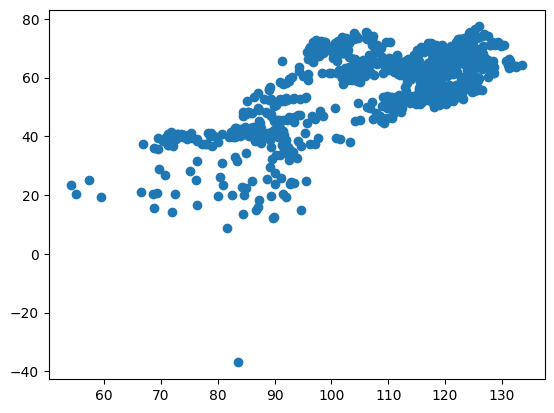

In [7]:
exo_arr = np.array(train_data['WTI Price'])
data_arr = np.array(train_data['Close'])
# vẽ biểu đồ scatter plot để xem sự tương quan giữa giá cổ phiếu XOM và giá trị biến ngoại sinh
plt.scatter(x = data_arr, y = exo_arr)
plt.show()

In [8]:
# Tìm hệ số tương quan giữa 2 cột Close và giá trị biến ngoại sinh
correlation = np.corrcoef(data_arr, exo_arr)[0, 1]

# In kết quả
print("Hệ số tương quan: ", correlation)

Hệ số tương quan:  0.6908869174220126


In [9]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.2 MB/s eta 0:00:00


In [10]:
# 3. Quá trình Training
train_exo = train_data[["WTI Price"]]

# Sử dụng auto_arima kèm biến ngoại sinh tìm ra model tốt nhất
from pmdarima.arima import auto_arima
model = auto_arima(train_data['Close'],
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      exogenous= train_exo)

# Gán các giá trị p, d, q vào các biến tương ứng
p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3998.499, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4032.684, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4023.730, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4025.056, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4030.917, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4023.543, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4023.789, Time=0.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4026.011, Time=6.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4023.079, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4025.205, Time=1.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4025.602, Time=2.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4001.486, Time=8.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3996.774, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [11]:
# Khởi tạo mô hình ARIMAX với order=(p, d, q) và khai báo biến ngoại sinh
model= SARIMAX(train_data['Close'],
 exog=train_exo,
 order=(p,d,q),
 enforce_invertibility=False, enforce_stationarity=False)

# Fit mô hình bằng dữ liệu huấn luyện để tìm ra các giá trị tối ưu cho các tham số của mô hình
model = model.fit()

In [12]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exo = test_data[['WTI Price']]
y_pred = model.forecast(steps=len(y_test), exog=test_exo)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exo = val_data[['WTI Price']]
y_pred_val =  model.forecast(steps=len(y_val), exog=val_exo)

In [13]:
# 6. Đánh giá độ chính xác thuật toán bằng RMSE
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_val- y_pred_val) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)

valid_mda = calculate_mda(np.squeeze(y_val), np.squeeze(y_pred_val))
test_mda = calculate_mda(np.squeeze(y_test), np.squeeze(y_pred))

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 74.40575729134328
Testing RMSE: 48.0852146955732
Validation MAPE: 42.95391765552825
Testing MAPE: 28.543555104569347
Validation MDA: 67.66917293233082
Testing MDA: 73.30827067669173


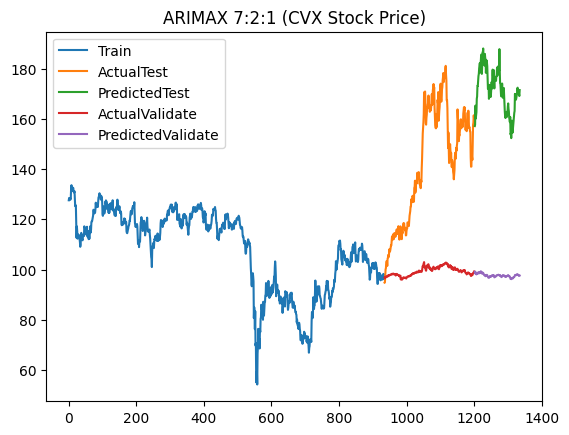

In [14]:
# 7.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.legend(['Train', 'ActualTest', 'PredictedTest','ActualValidate', 'PredictedValidate'])
plt.title('ARIMAX 7:2:1 (CVX Stock Price)')
plt.show()